# Exploring the OSHA chemical monitoring dataset
### Author: Jeff Minucci
### Date: 9/9/2019

In [24]:
%matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import zipfile
from tabulate import tabulate
from numba import jit
%matplotlib inline

Using matplotlib backend: Qt5Agg


### Load the dataset

In [25]:
if not 'data/osha/osha_monitoring_1984_2018.zip':
    with zipfile.ZipFile('data/osha/osha_monitoring_1984_2018.zip','r') as zfile:
        zfile.extractall('data/osha')
osha = pd.read_csv('data/osha/osha_monitoring_1984_2018.csv')

/home/jminucci/anaconda3/envs/occupation/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (1,8,12,13,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Load data on physio-chemical properties and molecular fingerprints of the chemicals sampled

In [26]:
chem_data = pd.read_csv('data/osha/osha_chem_properties.csv')
chem_data[chem_data.columns[8:]] = chem_data[chem_data.columns[8:]].apply(pd.to_numeric,errors='coerce')
chem_data.columns = [x.lower() for x in chem_data.columns]

### Clean and organize the data

In [27]:
osha.drop(osha.columns[0], axis=1, inplace=True)  # drop first column of old indices
osha['imis_substance_code'] = osha['imis_substance_code'].astype('category')
osha['sample_result'] = pd.to_numeric(osha['sample_result'], errors='coerce')
osha['air_volume_sampled'] = pd.to_numeric(osha['air_volume_sampled'], errors='coerce')

# keep only samples with units of concentration, or that we can convert to concentrations
osha = osha[osha['unit_of_measurement'].isin(['M', 'P', "%"]) | ((osha['unit_of_measurement'].isin(['X', 'Y'])) & osha['air_volume_sampled']>0)]

# keep only  sample types P=personal, A=area, B=bulk
osha = osha[osha['sample_type'].isin(['P','A', 'B'])]

# add average mol mass of the substances
osha = osha.merge(chem_data[['input', 'average_mass']], left_on='substance', right_on='input')

Convert all units to mg/m3

In [37]:
# convert all units to mg/m3
@jit(parallel=True, forceobj=True)
def convert_mg_m3(result, units, air_vol, mol_wt):
    n = len(result)
    concentrations = np.empty(n)
    for i in range(n):
        unit = units[i]
        x = result[i]
        vol = air_vol[i]
        mw = mol_wt[i]
        if unit == 'Y': # mg
            val = x/(vol*0.001)
        elif unit == 'X': # mcg
            val = (x/1000)/(vol*0.001)
        elif unit == '%': # percent
            val = (x*10000) * mw/24.45  # based on 25C and 1 atm
        elif unit == 'P':  
            val = x * mw/24.45  # based on 25C and 1 atm
        else:
            val = x
        concentrations[i] = val
    return concentrations

osha['conc_mgm3'] = convert_mg_m3(osha['sample_result'].to_numpy(), osha['unit_of_measurement'].to_numpy(dtype=str),
                                  osha['air_volume_sampled'].to_numpy(), osha['average_mass'].to_numpy())
#write unit converted dataset to file
#osha.to_csv('data/osha/osha_normalized.csv')

Merge our data on physio-chemical properties and molecular fingerprints

In [39]:
osha = osha.merge(chem_data[chem_data.columns.difference(['average_mass'])], left_on='substance', right_on='input')
osha.to_csv('data/osha/osha_add_features.csv')

### How many many substances are in our OSHA monitoring dataset?

In [40]:
osha.imis_substance_code.describe()

count     1879948
unique       1056
top          1591
freq       120347
Name: imis_substance_code, dtype: object

Ok so we have 1056 unique chemicals. 

How many substances occur frequently in the dataset?

In [22]:
thresholds = [2,10,50,100,500,1000, 5000, 10000]
counts = []
sub_counts = osha.imis_substance_code.value_counts()
for x in thresholds:
    counts.append(len(sub_counts[sub_counts >= x]))
print(tabulate({'Num of occurrences':thresholds, 'Num of substances':counts}, headers = 'keys', tablefmt='psql'))

+----------------------+---------------------+
|   Num of occurrences |   Num of substances |
|----------------------+---------------------|
|                    2 |                 977 |
|                   10 |                 653 |
|                   50 |                 387 |
|                  100 |                 286 |
|                  500 |                 144 |
|                 1000 |                 104 |
|                 5000 |                  46 |
|                10000 |                  31 |
+----------------------+---------------------+


Just a few substances are present an extremely large amount of times.

Let's look at the distribution when we remove these 'outliers'

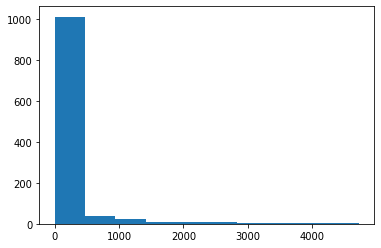

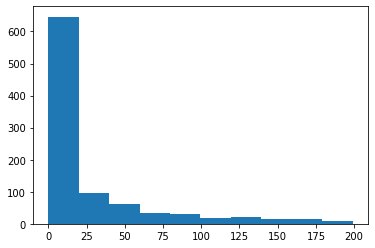

Median # of occurrences in osha monitoring: 15


In [147]:
sub_counts[sub_counts < 5000].hist(grid=False)
plt.show()
sub_counts[sub_counts < 200].hist(grid=False)
plt.show()
print('Median # of occurrences in osha monitoring: {:.0f}'.format(np.median(sub_counts)))

**IMIS code** isn't very meaningful without more info, but the substance column is poorly quality controlled, with some chemicals being named slightly differently.
Let's use fuzzy string matching to produce a list of the most commonly sampled substances by name.

In [108]:
counts_string = osha.substance.value_counts()
counts_string[counts_string < 1000].head()

Pyrene          977
DIACETYL        969
Isophorone      945
Phenanthrene    926
Cyclohexane     920
Name: substance, dtype: int64

In [160]:
# Write to csv a list of substance names
#substances = 
substance_list = osha.groupby('substance').count()
substance_list.to_csv('data/osha/substance_list.csv', header=True)

### What are the different units that sample measurements were taken in?

In [148]:
counts_units = osha.unit_of_measurement.value_counts()
counts_units.head(15)

M    1335322
P     310161
%     202162
Y      55366
X       1204
Name: unit_of_measurement, dtype: int64

In [122]:
osha[osha.sample_type=="['P', 'Y']"].tail()

inspection_number              establishment_name        city state  \
2114602             98775  Tompkins Aluminum Foundry Inc.  ROCK FALLS    IL   
2114603             98775  Tompkins Aluminum Foundry Inc.  ROCK FALLS    IL   
2114608            D28000                             NaN         NaN   NaN   
2114609            D28000                             NaN         NaN   NaN   
2114610            D28000                             NaN         NaN   NaN   

         zip_code  sic_code  naics_code          sampling_number  office_id  \
2114602   61071.0       NaN    331521.0       ['3284', '521400']        NaN   
2114603   61071.0       NaN    331521.0       ['3284', '521400']        NaN   
2114608       NaN       NaN         NaN  ['436522551', '215000']        NaN   
2114609       NaN       NaN         NaN  ['436522551', '215000']        NaN   
2114610       NaN       NaN         NaN  ['436522551', '215000']        NaN   

        date_sampled  ... sample_type blank_used time_sampled  \
2114602  2012-JAN-26  ...  ['P', 'Y']        NaN          NaN   
2114603  2012-JAN-26  ...  ['P', 'Y']        NaN          NaN   
2114608  2012-DEC-28  ...  ['P', 'Y']        NaN          NaN   
2114609  2012-DEC-28  ...  ['P', 'Y']        NaN          NaN   
2114610  2012-DEC-28  ...  ['P', 'Y']        NaN          NaN   

        air_volume_sampled sample_weight imis_substance_code  \
2114602                NaN           0.0                G301   
2114603                NaN           0.0                G302   
2114608                NaN           0.0                9135   
2114609                NaN           0.0                G301   
2114610                NaN           0.0                G302   

                                                 substance  sample_result  \
2114602                          Gravimetric Determination            0.0   
2114603                                      Sample Weight            0.0   
2114608  Particulates not otherwise regulated (Total Dust)            0.0   
2114609                          Gravimetric Determination            0.0   
2114610                                      Sample Weight            0.0   

        unit_of_measurement  qualifier  
2114602                   M     ND-BLK  
2114603                   Y     ND-BLK  
2114608                   M     ND-BLK  
2114609                   M     ND-BLK  
2114610                   Y     ND-BLK  

[5 rows x 25 columns]

In [128]:
osha[osha.unit_of_measurement=='N'].tail(25)

inspection_number establishment_name city state  zip_code  sic_code  \
2462567           1365892                NaN  NaN   NaN       NaN       NaN   
2462672           1366399                NaN  NaN   NaN       NaN       NaN   
2462800           1367048                NaN  NaN   NaN       NaN       NaN   
2462992           1367373                NaN  NaN   NaN       NaN       NaN   
2463032           1367401                NaN  NaN   NaN       NaN       NaN   
2463048           1367524                NaN  NaN   NaN       NaN       NaN   
2463076           1367711                NaN  NaN   NaN       NaN       NaN   
2463077           1367711                NaN  NaN   NaN       NaN       NaN   
2463078           1367711                NaN  NaN   NaN       NaN       NaN   
2463133           1368112                NaN  NaN   NaN       NaN       NaN   
2463140           1368399                NaN  NaN   NaN       NaN       NaN   
2463141           1368399                NaN  NaN   NaN       NaN       NaN   
2463142           1368399                NaN  NaN   NaN       NaN       NaN   
2463193            206524                NaN  NaN   NaN       NaN       NaN   
2463195            206524                NaN  NaN   NaN       NaN       NaN   
2463198            206524                NaN  NaN   NaN       NaN       NaN   
2463200            211112                NaN  NaN   NaN       NaN       NaN   
2463202            211112                NaN  NaN   NaN       NaN       NaN   
2463208         317722464                NaN  NaN   NaN       NaN       NaN   
2463217         317950448                NaN  NaN   NaN       NaN       NaN   
2463686         318104106                NaN  NaN   NaN       NaN       NaN   
2463688         318104106                NaN  NaN   NaN       NaN       NaN   
2463710        Q130304018                NaN  NaN   NaN       NaN       NaN   
2463711        Q130304018                NaN  NaN   NaN       NaN       NaN   
2463712        Q130304018                NaN  NaN   NaN       NaN       NaN   

         naics_code sampling_number  office_id date_sampled  ... sample_type  \
2462567         NaN          331588   728500.0  2018-DEC-12  ...           B   
2462672         NaN          323861   625500.0  2018-DEC-14  ...           B   
2462800         NaN          332175   418100.0  2018-DEC-18  ...           B   
2462992         NaN          332324   111700.0  2018-DEC-20  ...           B   
2463032         NaN          333632   316700.0  2018-DEC-19  ...           B   
2463048         NaN          332130   418200.0  2018-DEC-20  ...           B   
2463076         NaN          332193   418400.0  2018-DEC-19  ...           B   
2463077         NaN          332193   418400.0  2018-DEC-19  ...           B   
2463078         NaN          332193   418400.0  2018-DEC-19  ...           B   
2463133         NaN          332318   317000.0  2018-DEC-26  ...           B   
2463140         NaN          332482   626000.0  2018-DEC-28  ...           B   
2463141         NaN          332482   626000.0  2018-DEC-28  ...           B   
2463142         NaN          332482   626000.0  2018-DEC-28  ...           B   
2463193         NaN          319658   894601.0  2018-JUL-09  ...           B   
2463195         NaN          319658   894601.0  2018-JUL-09  ...           B   
2463198         NaN          319658   894601.0  2018-JUL-09  ...           B   
2463200         NaN          326781   190901.0  2018-OCT-09  ...           B   
2463202         NaN          326784   190901.0  2018-OCT-09  ...           B   
2463208         NaN    OR2018121301  1054191.0  2018-NOV-20  ...           B   
2463217         NaN    WA2018081601  1055300.0  2018-AUG-01  ...           B   
2463686         NaN       436974018   551800.0  2018-OCT-09  ...           B   
2463688         NaN       436974026   551800.0  2018-OCT-09  ...           B   
2463710         NaN    CA2018060401   950662.0  2018-MAY-31  ...           B   
2463711         NaN    CA20180604

In [36]:
osha

inspection_number                establishment_name              city  \
0                  111211          CONTROLLED CASTINGS CORP         Plainview   
1                  111211          CONTROLLED CASTINGS CORP         Plainview   
2                  111252    MID ISLAND NON FERROUS FOUNDRY  East Farmingdale   
3                  111252    MID ISLAND NON FERROUS FOUNDRY  East Farmingdale   
4                  114645         TRILECTRON INDUSTRIES INC         Hawthorne   
...                   ...                               ...               ...   
1879943           1319014           Monument Pharmacy, Inc.          MONUMENT   
1879944           1319014           Monument Pharmacy, Inc.          MONUMENT   
1879945           1319014           Monument Pharmacy, Inc.          MONUMENT   
1879946           1319014           Monument Pharmacy, Inc.          MONUMENT   
1879947           1321471  McCorvey Sheet Metal Works, L.P.           ORLANDO   

        state  zip_code  sic_code  naics_code sampling_number  office_id  \
0          NY   11803.0    3365.0         0.0     5.24554e+06   214700.0   
1          NY   11803.0    3365.0         0.0      5.2455e+06   214700.0   
2          NY   11735.0    3365.0         0.0     5.24534e+06   214700.0   
3          NY   11735.0    3365.0         0.0     5.24534e+06   214700.0   
4          NJ    7506.0    3612.0         0.0     5.26995e+06   214500.0   
...       ...       ...       ...         ...             ...        ...   
1879943    CO   80132.0       NaN    446110.0          313202   830600.0   
1879944    CO   80132.0       NaN    446110.0          313204   830600.0   
1879945    CO   80132.0       NaN    446110.0          313204   830600.0   
1879946    CO   80132.0       NaN    446110.0          313204   830600.0   
1879947    FL   32824.0       NaN    332322.0          316497   420600.0   

                date_sampled  ... air_volume_sampled sample_weight  \
0        1984/05/07 00:00:00  ...           516.0000           NaN   
1        1984/05/07 00:00:00  ...            76.0000           NaN   
2        1984/04/04 00:00:00  ...            74.0000           0.0   
3        1984/04/04 00:00:00  ...             0.0000           0.0   
4        1984/04/16 00:00:00  ...           240.0000           NaN   
...                      ...  ...                ...           ...   
1879943          2018-MAY-31  ...           243.6000           NaN   
1879944          2018-MAY-31  ...           195.9400           NaN   
1879945          2018-MAY-31  ...           270.6800           NaN   
1879946          2018-MAY-31  ...                NaN           NaN   
1879947          2018-JUN-13  ...            46.7285           NaN   

        imis_substance_code                substance sample_result  \
0                      T100                  Thorium      0.000500   
1                      T100                  Thorium      0.016000   
2                      1591  Lead, Inorganic (as Pb)      0.064000   
3                      1591  Lead, Inorganic (as Pb)      0.000000   
4                      1591  Lead, Inorganic (as Pb)      0.000000   
...                     ...                      ...           ...   
1879943                A617     Antineoplastic Drugs      0.000000   
1879944                A617     Antineoplastic Drugs      0.000000   
1879945                A617     Antineoplastic Drugs      0.000000   
1879946                A617     Antineoplastic Drugs      0.000000   
1879947                M116       Methylcyclopentane      6.893431   

        unit_of_measurement qualifier                    input  average_mass  \
0                         M       NaN                  Thorium      232.0377   
1                         M       NaN                  Thorium      232.0377   
2                         M       NaN  Lead, Inorganic (as Pb)      207.2000   
3                         M       BLK  Lead, Inorganic (as Pb)      207.2000   
4                         M        ND  L